# Speech Emotion Recognition

**Liam O'Driscoll**

The point of this notebook is to classify wav files by emotion using a Convolutional Neural Network.

**Begin by importing necesarry packages**

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

import keras
import tensorflow
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd


# Part 1 - The Data

**The dataset I composed was created by combining the following Emotional Speech Datasets [RAVDESS](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio), [CREMA-D](https://www.kaggle.com/datasets/ejlok1/cremad), [TESS](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess), [SAVEE](https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee). Since we are working with wav files the entire dataset would have been way too large to include in this notebook and repository, so instead I will include a csv file with all of the necessary MFCCs in the ./Data/ directory. We begin by taking a look at a few examples that can be found in the ./Audio/ directory**

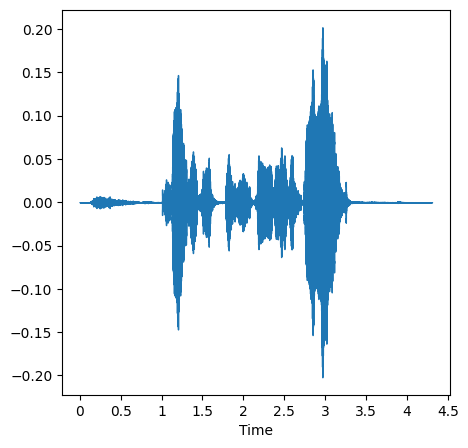

In [21]:
x, sr = librosa.load('./Audio/angry.wav')
plt.figure(figsize=(5, 5))
librosa.display.waveshow(x, sr=sr)

In [22]:
ipd.Audio('./Audio/angry.wav')

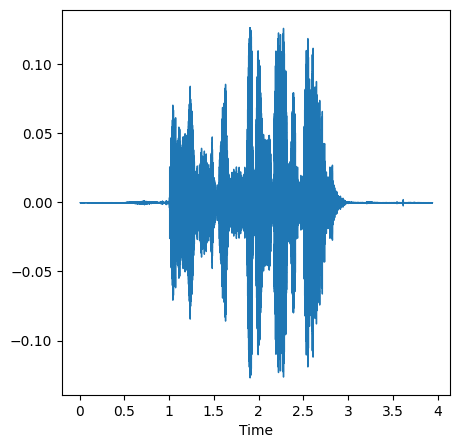

In [23]:
x, sr = librosa.load('./Audio/happy.wav')
plt.figure(figsize=(5, 5))
librosa.display.waveshow(x, sr=sr)

In [24]:
ipd.Audio('./Audio/happy.wav')

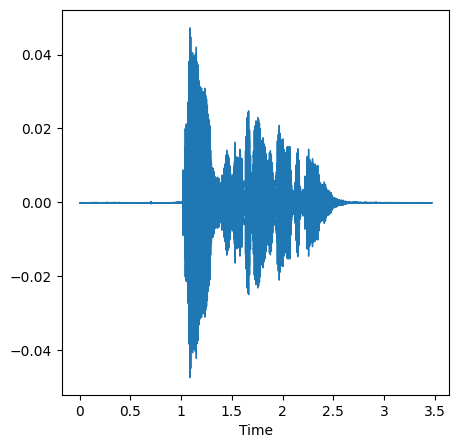

In [25]:
x, sr = librosa.load('./Audio/sad.wav')
plt.figure(figsize=(5, 5))
librosa.display.waveshow(x, sr=sr)

In [26]:
ipd.Audio('./Audio/sad.wav')

**As you can see the three differing emotions look very similar as simple wave representations. We will use 58 MFCCs instead to capture their differences. The dataset is split into male and female voices. To increase generality beyond the dataset we will combine male and female voices into a joint dataset and train the network on this dataset.**

In [2]:
male_data = pd.read_csv('./Data/Male_features.csv')
female_data = pd.read_csv('./Data/Female_features.csv')

# Part 2 - Creating Training and Test data

Since this is a multiclass problem we will one hot encode the labels and as with most NNs we normalize the data before splitting it. 

In [3]:
# create y first
encoder = OneHotEncoder()

mlabels = male_data['labels'].values
male_y = encoder.fit_transform(np.array(mlabels).reshape(-1,1)).toarray()

flabels = female_data['labels'].values
female_y = encoder.fit_transform(np.array(flabels).reshape(-1,1)).toarray()

#create X
scaler = StandardScaler()

male_X = scaler.fit_transform(np.array(male_data.iloc[:, :-1], dtype = float))
female_X = scaler.fit_transform(np.array(female_data.iloc[:, :-1], dtype = float))

#join
y = np.concatenate((male_y, female_y))
X = np.concatenate((male_X, female_X))

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [4]:
#expand dims to make compatible with model
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

X_train.shape, X_test.shape

((76620, 58, 1), (8514, 58, 1))

# Part 3 - Building the Model

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Model Architecture Discussion



In [9]:
model=Sequential()

model.add(Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(58, 1)))
model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=4, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [12]:
history = model.fit(X_train,
                    y_train,
                    batch_size=1000,
                    epochs=75,
                    validation_split=0.1,
                    )

Epoch 1/75
48/69 [===================>..........] - ETA: 17s - loss: 1.3695 - accuracy: 0.4623

KeyboardInterrupt: 

# Part 4 - Model Evaluation

# Part 5 - Try it for Yourself!